Customer ID: 1,Customer type: 0 Demand: 0
Customer ID: 2,Customer type: 1 Demand: 33.0
Customer ID: 3,Customer type: 1 Demand: 15.0
Customer ID: 4,Customer type: 1 Demand: 10.0
Customer ID: 5,Customer type: 1 Demand: 40.0
Customer ID: 6,Customer type: 1 Demand: 15.0
Customer ID: 7,Customer type: 1 Demand: 5.0
Customer ID: 8,Customer type: 1 Demand: 77.0
Customer ID: 9,Customer type: 1 Demand: 435.0
Customer ID: 10,Customer type: 1 Demand: 165.0
Customer ID: 11,Customer type: 1 Demand: 120.0
Customer ID: 12,Customer type: 1 Demand: 65.0
Customer ID: 13,Customer type: 1 Demand: 23.0
Customer ID: 14,Customer type: 1 Demand: 18.0
Customer ID: 15,Customer type: 1 Demand: 550.0
Customer ID: 16,Customer type: 1 Demand: 78.0
Customer ID: 17,Customer type: 1 Demand: 627.0
Customer ID: 18,Customer type: 1 Demand: 9.0
Customer ID: 19,Customer type: 1 Demand: 96.0
Customer ID: 20,Customer type: 1 Demand: 116.0
Customer ID: 21,Customer type: 1 Demand: 116.0
Customer ID: 22,Customer type: 1 Demand: 

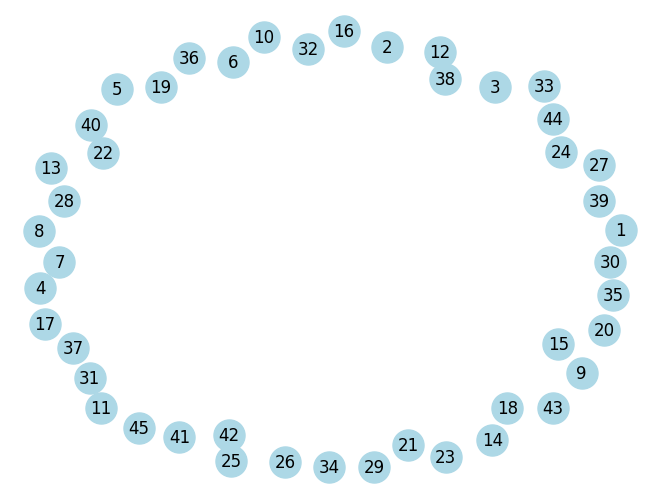

In [44]:
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
path = '../data/fisher-1994-set-f/F-n045-k4.xml'
def transfer_xml_to_nxgraph(path):
    # Load the VRP-REP XML file
    tree = ET.parse(path)
    root = tree.getroot()
    G = nx.DiGraph()

    #for elem in root.iter():
    #    print(f'Element: {elem.tag}, Attributes: {elem.attrib}')
    #    if elem.text is not None:
    #        print(f'  Text: {elem.text.strip()}')

    # Print specific elements of interest
    for customer in root.findall('./network/nodes/node'):
        id = customer.get('id')
        cx = customer.find('cx').text  # Get the text content of <cx>
        cy = customer.find('cy').text 
        pos = (cx,cy)
        type = customer.get('type')
        if(id !='1'):
            demand_item = root.find(f"./requests/request[@node='{id}']")
            demand_sin = demand_item.find('quantity').text
        else:
            demand_sin = 0
        G.add_node(id,pos=pos,demand = demand_sin)
        print(f'Customer ID: {id},Customer type: {type} Demand: {demand_sin}')
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=500)

    # Display the plot
    plt.show()
    return G
transfer_xml_to_nxgraph(path)

We want to generate the Hij term for Qij in QUBO.

In [45]:
num_customers = 3
position = 3
A = 1.5 # penalty coefficient A >max{d}
B=1 
array = np.random.rand(num_customers,num_customers)
D = array


In [46]:
import itertools
distances = D
# Generate all permutations of the cities, excluding the first city to fix the starting point
perms = list(itertools.permutations(range(1, len(distances))))

# Initialize minimum distance to a large number
min_distance = float('inf')
best_route = None

# Check each permutation
for perm in perms:
    # Include the starting city at the beginning and the end to complete the cycle
    route = (0,) + perm + (0,)
    # Calculate the total distance of the current permutation
    current_distance = sum(distances[route[i]][route[i+1]] for i in range(len(route) - 1))
    
    # Update minimum distance and best route
    if current_distance < min_distance:
        min_distance = current_distance
        best_route = route

min_distance, best_route


(1.3143828330011376, (0, 2, 1, 0))

In [47]:
def calculate_Q(num_customers,position,A,B,weight):
    
    Q = np.zeros((num_customers*position,num_customers*position))
    for k in range(num_customers):
        for i in range(position):
            for j in range(position):
                if i == j:
                    Q[i+k*position, j+k*position] = -A 
                else:
                    Q[i+k*position, j+k*position] += 2*A
                    
    for k in range(position):
        for i in range(num_customers):
            for j in range(num_customers):
                if i == j:
                    Q[k+i*position, k+j*position] += -A 
                else:
                    Q[k+i*position, k+j*position] += 2*A
                    
    for k in range(num_customers):
        for i in range(num_customers):
                for j in range(position):
                    if i != k:
                        Q[k*position+j, i*position+(j+1)%position] += B*weight[k,i]
                        Q[k*position+j, i*position+(j-1)%position] += B*weight[i,k]

    return Q
Qubo = calculate_Q(num_customers = num_customers,position = position,A = A,B=B,weight =D)


In [48]:
np.set_printoptions(precision=2, suppress=True)
def print_matrix(matrix):
    for row in matrix:
        print(" ".join(map(str, row)))
print_matrix(Qubo)

-3.0 3.0 3.0 3.0 0.1942974852130065 0.26938469527986364 3.0 0.08190006001834516 0.696724843853251
3.0 -3.0 3.0 0.26938469527986364 3.0 0.1942974852130065 0.696724843853251 3.0 0.08190006001834516
3.0 3.0 -3.0 0.1942974852130065 0.26938469527986364 3.0 0.08190006001834516 0.696724843853251 3.0
3.0 0.26938469527986364 0.1942974852130065 -3.0 3.0 3.0 3.0 0.5467772453446605 0.9630980777029287
0.1942974852130065 3.0 0.26938469527986364 3.0 -3.0 3.0 0.9630980777029287 3.0 0.5467772453446605
0.26938469527986364 0.1942974852130065 3.0 3.0 3.0 -3.0 0.5467772453446605 0.9630980777029287 3.0
3.0 0.696724843853251 0.08190006001834516 3.0 0.9630980777029287 0.5467772453446605 -3.0 3.0 3.0
0.08190006001834516 3.0 0.696724843853251 0.5467772453446605 3.0 0.9630980777029287 3.0 -3.0 3.0
0.696724843853251 0.08190006001834516 3.0 0.9630980777029287 0.5467772453446605 3.0 3.0 3.0 -3.0


In [49]:
def get_maxcutGraph_weight(Qubo,n):
    maxcutG = (Qubo + Qubo.T)/2
    extended_array = np.zeros((n+1,n+1))
    extended_array[1:n+1,1:n+1] = maxcutG
    for i in range(n):
        for j in range(n):
            if(i!=j):
                extended_array[0,i] += 0.5*(Qubo[i,j]+Qubo[j,i])
            else:
                extended_array[0,i] += (Qubo[i,i])
    for i in range(n-1):
        extended_array[i+1,0] = extended_array[0,i]
    return extended_array
maxcut = get_maxcutGraph_weight(Qubo,num_customers*position) 
print(maxcut)          

[[10.24 10.24 10.24 10.97 10.97 10.97 11.29 11.29 11.29  0.  ]
 [10.24 -3.    3.    3.    3.    0.19  0.27  3.    0.08  0.7 ]
 [10.24  3.   -3.    3.    0.27  3.    0.19  0.7   3.    0.08]
 [10.24  3.    3.   -3.    0.19  0.27  3.    0.08  0.7   3.  ]
 [10.97  3.    0.27  0.19 -3.    3.    3.    3.    0.55  0.96]
 [10.97  0.19  3.    0.27  3.   -3.    3.    0.96  3.    0.55]
 [10.97  0.27  0.19  3.    3.    3.   -3.    0.55  0.96  3.  ]
 [11.29  3.    0.7   0.08  3.    0.96  0.55 -3.    3.    3.  ]
 [11.29  0.08  3.    0.7   0.55  3.    0.96  3.   -3.    3.  ]
 [ 0.    0.7   0.08  3.    0.96  0.55  3.    3.    3.   -3.  ]]


In [50]:
n = num_customers*position +1  # the node for QAOA to solve

In [51]:
import cudaq
from cudaq import spin

from typing import List
cudaq.set_target('nvidia')
maxcut_list = maxcut.flatten().tolist()
print(maxcut_list)
# Here we build up a kernel for QAOA with `p` layers, with each layer
# containing the alternating set of unitaries corresponding to the problem
# and the mixer Hamiltonians. The algorithm leverages the VQE algorithm
# to compute the Max-Cut of a rectangular graph illustrated below.

#       v0  0---------------------0 v1
#           |                     |
#           |                     |
#           |                     |
#           |                     |
#       v3  0---------------------0 v2
# The Max-Cut for this problem is 0101 or 1010.
hamiltonian = 0
# The problem Hamiltonian
for i in range(n):
    for j in range(n):
        hamiltonian += 0.5*maxcut_list[i*n+j]*spin.z(i) * spin.z(j)
        
#hamiltonian = 0.5 * spin.z(0) * spin.z(1) + 0.5 * spin.z(1) * spin.z(2) \
#       + 0.5 * spin.z(0) * spin.z(3) + 0.5 * spin.z(2) * spin.z(3)

# Problem parameters.
qubit_count: int = n
layer_count: int = 2
parameter_count: int = 2 * layer_count


@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float],h1:List[float]):
    """QAOA ansatz for Max-Cut"""
    qvector = cudaq.qvector(qubit_count)
    # Create superposition
    h(qvector)

    # Loop over the layers
    for layer in range(layer_count):
        # Loop over the qubits
        # Problem unitary
        for qubit1 in range(qubit_count):
            for qubit2 in range(qubit_count):
                if(qubit1>qubit2):
                    x.ctrl(qvector[qubit1], qvector[(qubit2 ) % qubit_count])
                    rz(2.0 * maxcut_list[qubit1*qubit_count+qubit2]*thetas[layer], qvector[(qubit2) % qubit_count])
                    x.ctrl(qvector[qubit1], qvector[(qubit2) % qubit_count])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])
            rz(-2.0 * h1*thetas[layer + layer_count], qvector[qubit])


# Specify the optimizer and its initial parameters. Make it repeatable.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.COBYLA()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         parameters).expectation()

# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, optimal_parameters)
print(counts)

[10.242307084364466, 10.242307084364466, 10.242307084364466, 10.97355750354046, 10.973557503540459, 10.97355750354046, 11.288500226919185, 11.288500226919185, 11.288500226919187, 0.0, 10.242307084364466, -3.0, 3.0, 3.0, 3.0, 0.1942974852130065, 0.26938469527986364, 3.0, 0.08190006001834516, 0.696724843853251, 10.242307084364466, 3.0, -3.0, 3.0, 0.26938469527986364, 3.0, 0.1942974852130065, 0.696724843853251, 3.0, 0.08190006001834516, 10.242307084364466, 3.0, 3.0, -3.0, 0.1942974852130065, 0.26938469527986364, 3.0, 0.08190006001834516, 0.696724843853251, 3.0, 10.97355750354046, 3.0, 0.26938469527986364, 0.1942974852130065, -3.0, 3.0, 3.0, 3.0, 0.5467772453446605, 0.9630980777029287, 10.973557503540459, 0.1942974852130065, 3.0, 0.26938469527986364, 3.0, -3.0, 3.0, 0.9630980777029287, 3.0, 0.5467772453446605, 10.97355750354046, 0.26938469527986364, 0.1942974852130065, 3.0, 3.0, 3.0, -3.0, 0.5467772453446605, 0.9630980777029287, 3.0, 11.288500226919185, 3.0, 0.696724843853251, 0.0819000600

In [52]:
def find_ones_positions(binary_number):
    positions = []
    for i, bit in enumerate(binary_number):
        if bit == '1':
            positions.append(i)
    return positions
def flip_binary(binary_number):
    flipped_number = ''.join('1' if bit == '0' else '0' for bit in binary_number)
    return flipped_number
def string_to_graph(str,num_node):
    if(str[0]=='0'):
        flipped_num = True
    else:
        flipped_num = False
    str_ = str[1:] if flipped_num else flip_binary(str[1:])
    result_dir = {}
    for i in range(num_node):
        result_dir[f'{i+1}'] = find_ones_positions(str[1+i*num_node:1+(i+1)*(num_node)])
    
    return result_dir
string_to_graph(str(counts.most_probable()),num_customers)   
    

{'1': [0, 1, 2], '2': [0, 1, 2], '3': [0, 1, 2]}

most probable state:0111111111


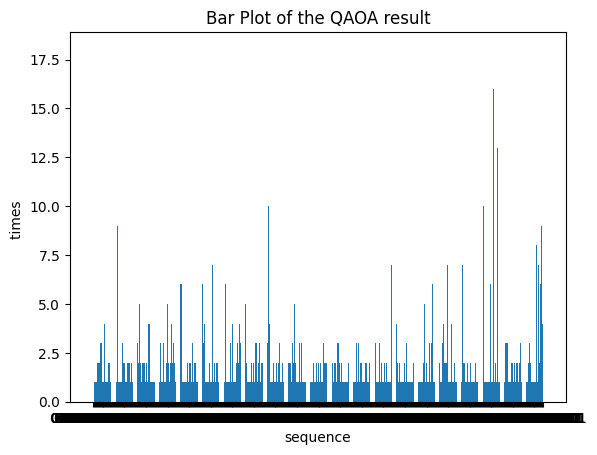

In [53]:
keys=[]
values = []
print(f'most probable state:{counts.most_probable()}')
# Extract keys and values
for x,y in counts.items():
    keys.append(x)
    values.append(y)
# Create a bar plot
plt.bar(keys, values)

# Add labels and title
plt.xlabel('sequence')
plt.ylabel('times ')
plt.title('Bar Plot of the QAOA result')

# Show the plot
plt.show()